# Podcast Recommender System 

#### Author Eu Jin Lee: [LinkedIn](https://www.linkedin.com/in/eeujinlee/) | [GitHub](https://github.com/MissingNA)

![podcast_competitors](../images/podcast_comp.png)<img src="./images/bee.png" width="200"/>

## Problem Statement 

The advent of podcasts started in late 2004 with the public's greater accesibility to broadband Internet and portable digital audio playback devices such as the iPod. This allowed people to explore the digital media space by developing episodic series of spoken word through digital audio files that could be downloaded onto your personal device for easy listening. Discussion and content within a podcast can range from carefully scripted to totally improvised. Podcasts combine elaborate and artistic sound production with thematic concerns ranging from scientific research to slice-of-life journalism.

However in recent years, podcasting has become a disruptive and popular medium to invest in and use as a commercial platform. 

As the podcast wars intensifies, major players such as Spotify, Apple's iTunes, Pandora and iHeartRadio are rushing to claim dominance within the media space. And one of the ways that has proven to much success in establishing that dominant position is by developing a reliable and accurate recommendation system for their podcast service platforms.  

Our goal is to build a recommendation system based on the podcast descriptors and categories as driving features for our model to create those recommendations.

This recommendation system will then be onboarded onto a front facing website interface that users can interact with by building an app with Flask and hosting our application on Heroku. 

## Executive Summary

The workflow of the projects is as follows:
- Importing packages, preliminary data processing, data cleaning & EDA
- Building out components for the Recommender Engine
- Constructing and running a test with the Recommender Engine
- Using Recommender Engine to generate a recommendations database
- Develop the capability to generate predictions with unseen data
- Conclusions and Recommendations

For the purposes of this project, data was sourced from a dataset made available through Kaggle; with over ~121 thousand+ rows of iTunes podcast data from Listen Notes, a podcast search engine. Making it one of the most comprehensive podcast databases that you can find on the Internet. For the project, English podcasts were the primary focus for building the recommendation engine which constitutes about 81.9% (99,316 / 121,175) of the podcasts dataset. However during the process, it is found that the dataset did have a couple discrepancies which will be addressed in the Conclusions and Recommendations. 

The main idea of the recommendation engine is centered around vectorizing the podcast descriptions and binarizing the categories to generate a similarity matrix using scikit-learn Natural Lanaguage Processing (NLP) libraries. The similarity matrix allows us to observe the coefficients of similarity (likeness) of a reference podcast to each one of the other tenths of thousands of podcast. And the results are suprisingly reliable! 

The recommendation system that has been created is a good example of content-based collaborative filtering technique that is commonly used. The recommendation systems used in industry today would likely be a more comprehensive and robust version of this, incorporating hundreds or even thousands of data sources and types. 

## Table of Contents

- [Data Dictionary](#Data-Dictionary)
- [Import Packages](#Import-Packages)
- [Podcast Dataset](#Podcast-Dataset)
    - [Data Import and EDA](#Data-Import-and-EDA)
- [Buiding Recommendation Engine](#Building-Recommendation-Engine)
    - [Constructing categories matrix](#Constructing-categories-matrix)
    - [Generating recommendations](#Generating-recommendations)
        - [TFIDFVectorizer test](#TFIDFVectorizer-test)
        - [CountVectorizer test](#CountVectorizer-test)
        - [Building sparse matrix](#Building-sparse-matrix)
        - [Top 5 Recommendations test](#Top-5-Recommendations-test)
- [Generating Recommendations Database](#Generating-Recommendations-Database)
    - [LookUp function for podcast recommendations](#LookUp-function-for-podcast-recommendations)
- [Generating recommendations on unseen data](#Generating-recommendations-on-unseen-data)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)
- [References](#References)

## Data Dictionary

### Podcast Data 

| Features    | Type   | Description                              |
|-------------|--------|------------------------------------------|
| uuid        | object | Listen Notes dataset id                  |
| title       | object | title of the podcast                     |
| image       | object | logo of podcast                          |
| description | object | short descriptive text about the podcast |
| language    | object | language of podcast                      |
| categories  | object | associated categories of podcast         |
| website     | object | website url of podcast                   |
| author      | object | authors/contributors of the podcast      |
| itunes_id   | int64  | iTunes podcast id                        |

### Recommendations Data (generated)

| Features    | Type   | Description                     |
|-------------|--------|---------------------------------|
| ref_podcast | object | referenced podcast              |
| first_rec   | object | top recommended podcast         |
| second_rec  | object | second most recommended podcast |
| third_rec   | object | third most recommended podcast  |
| fourth_rec  | object | fourth most recommended podcast |
| fifth_rec   | object | fifth most recommended podcast  |

## Import Packages

In [79]:
#Standard Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from scipy import sparse
from scipy.sparse import hstack

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('max_columns', 70)

## Podcast Dataset

### Data Import and EDA 

In [80]:
podcasts = pd.read_csv('../data/podcasts.csv')

In [81]:
podcasts.shape

(121175, 9)

In [82]:
podcasts.head(5)

,uuid,title,image,description,language,categories,website,author,itunes_id
0,8d62d3880db2425b890b986e58aca393,"Ecommerce Conversations, by Practical Ecommerce",http://is4.mzstatic.com/image/thumb/Music6/v4/...,Listen in as the Practical Ecommerce editorial...,English,Technology,http://www.practicalecommerce.com,Practical Ecommerce,874457373
1,cbbefd691915468c90f87ab2f00473f9,Eat Sleep Code Podcast,http://is4.mzstatic.com/image/thumb/Music71/v4...,On the show we’ll be talking to passionate peo...,English,Tech News | Technology,http://developer.telerik.com/,Telerik,1015556393
2,73626ad1edb74dbb8112cd159bda86cf,SoundtrackAlley,http://is5.mzstatic.com/image/thumb/Music71/v4...,A podcast about soundtracks and movies from my...,English,Podcasting | Technology,https://soundtrackalley.podbean.com,Randy Andrews,1158188937
3,0f50631ebad24cedb2fee80950f37a1a,The Tech M&A Podcast,http://is1.mzstatic.com/image/thumb/Music71/v4...,The Tech M&A Podcast pulls from the best of th...,English,Business News | Technology | Tech News | Business,http://www.corumgroup.com,Timothy Goddard,538160025
4,69580e7b419045839ca07af06cf0d653,"The Tech Informist - For fans of Apple, Google...",http://is4.mzstatic.com/image/thumb/Music62/v4...,The tech news show with two guys shooting the ...,English,Gadgets | Tech News | Technology,http://techinformist.com,The Tech Informist,916080498


In [83]:
podcasts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121175 entries, 0 to 121174
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uuid         121175 non-null  object
 1   title        121173 non-null  object
 2   image        121175 non-null  object
 3   description  119832 non-null  object
 4   language     121175 non-null  object
 5   categories   121175 non-null  object
 6   website      120005 non-null  object
 7   author       118678 non-null  object
 8   itunes_id    121175 non-null  int64 
dtypes: int64(1), object(8)
memory usage: 8.3+ MB


#### Languages in Podcast Dataset

In [84]:
podcasts.language.value_counts()

English             99316
German               4316
French               3874
Spanish              3637
Portuguese           1827
Swedish              1698
Chinese              1329
Japanese             1097
Italian               818
Russian               602
Dutch                 531
Norwegian             435
Danish                337
Korean                190
Finnish               157
Polish                145
Estonian              128
Czech                 119
Turkish               116
Catalan                93
Slovenian              79
Hungarian              72
Romanian               39
Galician               37
Ukranian               30
Slovak                 22
Swahili                21
Indonesian             19
Greek                  13
Icelandic              13
Basque                 13
Afrikaans              13
Bulgarian               9
Serbian                 8
Albanian                6
Croatian                5
Abkhazian               3
Irish                   3
Afar        

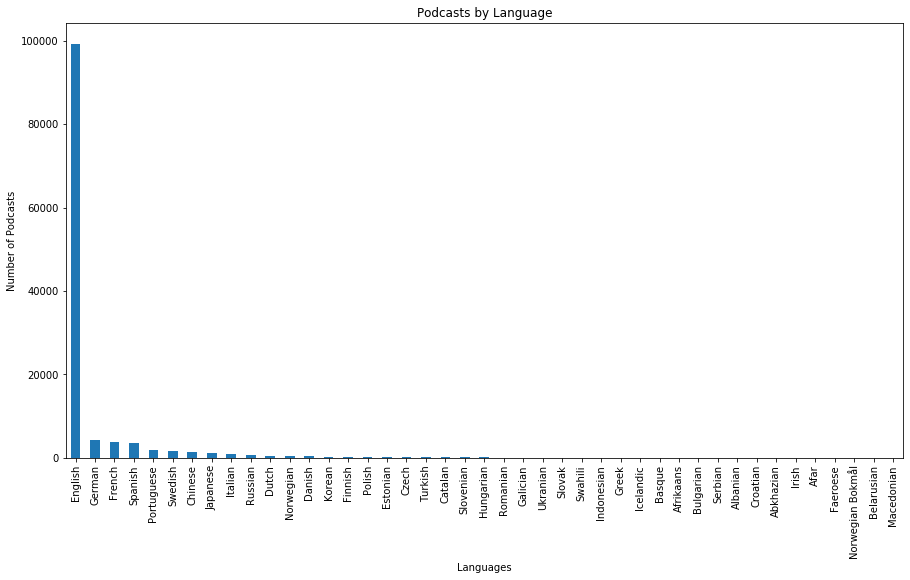

In [91]:
plt.figure(figsize=(15,8))
podcasts['language'].value_counts().plot.bar()
plt.title('Podcasts by Language')
plt.xlabel('Languages')
plt.ylabel('Number of Podcasts');

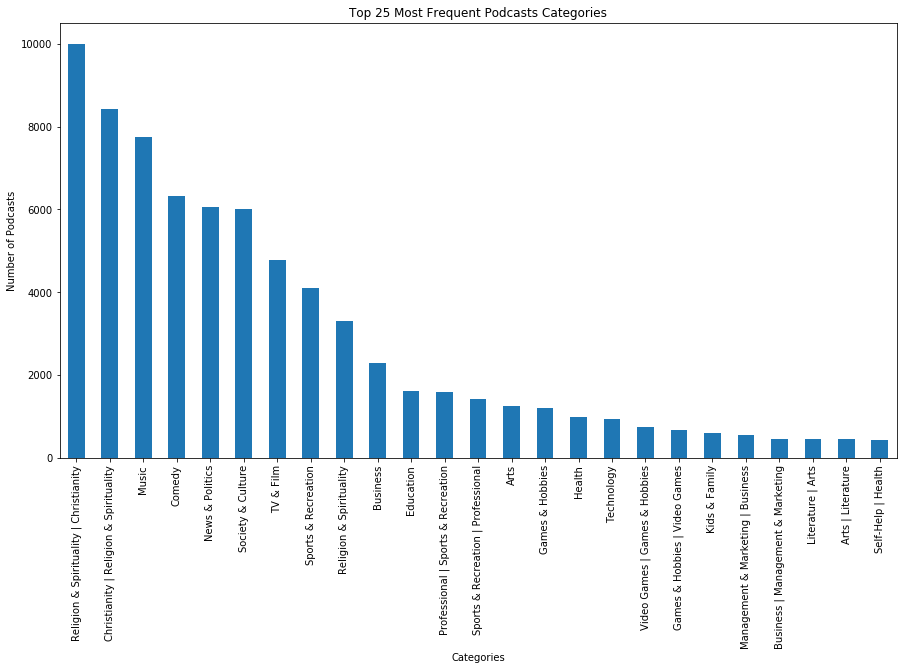

In [98]:
plt.figure(figsize=(15,8))
podcasts['categories'].value_counts()[:25].plot.bar()
plt.title('Top 25 Most Frequent Podcasts Categories')
plt.xlabel('Categories')
plt.ylabel('Number of Podcasts');

#### Filtering for English podcast 

In [7]:
podcasts = podcasts[podcasts.language == 'English']

#### Removing podcast with missing descriptions and duplicate ids

In [8]:
podcasts = podcasts.dropna(subset=['description'])
podcasts = podcasts.drop_duplicates('itunes_id')

In [9]:
podcasts.description.isnull().sum()

0

#### Filtering for podcast descriptions greater than 20 words 

In [10]:
podcasts['description_length'] = [len(x.description.split()) for _, x in podcasts.iterrows()]

In [11]:
podcasts['description_length'].describe()

count    98173.000000
mean        39.168753
std        107.098547
min          0.000000
25%         11.000000
50%         26.000000
75%         51.000000
max      30157.000000
Name: description_length, dtype: float64

About 25\% of our descriptions have less than 11 words or less. Hence, a fair assumption that these won't serve as good inputs when we build the recommender system. Just to be safe, we are only including descriptions that have at least 20 words in them.

In [12]:
podcasts = podcasts[podcasts.description_length >= 20]

## Building Recommendation Engine 

### Constructing categories matrix 

#### Tokenizing and dummifying categories to form a categories matrix 

In [13]:
podcasts.shape

(59322, 10)

In [14]:
podcasts.categories.fillna('None', inplace=True)

In [15]:
unique_categories = podcasts.categories.unique()

In [16]:
final_categories = set()
for category in unique_categories: 
    strip_cats = [cat_split.strip() for cat_split in category.split('|')]
    for strip_cat in strip_cats:
        final_categories.add(strip_cat)
new_features = list(final_categories)

In [17]:
# convert list into columns and append to podcast dataframe 
category_df = pd.DataFrame()
# run a loop to check if categories column has the word in each of the new columns 1 for yes 0 for no
for column_name in new_features:
    boolean_series = podcasts.categories.str.contains(column_name).astype(int)
    category_df[column_name] = boolean_series

In [18]:
category_df.shape

(59322, 67)

In [19]:
category_df.head()

,News & Politics,Hobbies,Personal Journals,Higher Education,Sexuality,Buddhism,Careers,Other,Podcasting,Other Games,Social Sciences,Software How-To,Medicine,Education,Judaism,Regional,Investing,Games & Hobbies,National,Local,Alternative Health,Training,Business News,Self-Help,Fitness & Nutrition,Philosophy,Health,Language Courses,History,Amateur,Society & Culture,Shopping,Outdoor,Spirituality,Places & Travel,Islam,Science & Medicine,Arts,Technology,Design,Comedy,Literature,Management & Marketing,Visual Arts,Business,Government & Organizations,Food,Christianity,Non-Profit,Video Games,Performing Arts,Religion & Spirituality,K-12,TV & Film,Tech News,Educational Technology,Fashion & Beauty,Sports & Recreation,Hinduism,Natural Sciences,Kids & Family,College & High School,Aviation,Professional,Gadgets,Automotive,Music
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
9,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
category_df = category_df / 125

Due to the dominance of the categories matrix, added takes a larger precendence when generating recommendations. Hence, the categories matrix is manually standardized in the cell above. The reason for the standardization process done manually is because there were some constraints and limitations in the data dimensions when considered using scaling techniques such as StandardScaler, MinMaxAbs and MaxAbs. 

### Generating recommendations 

**NOTE**: TFIDFVec vers. have been commented out to avoid RAM overload.

In [21]:
podcasts['description'] = podcasts['description'].astype(str)

In [22]:
podcasts.shape

(59322, 10)

In [23]:
podcasts = podcasts.reset_index()

In [24]:
podcasts.head(3)

,index,uuid,title,image,description,language,categories,website,author,itunes_id,description_length
0,1,cbbefd691915468c90f87ab2f00473f9,Eat Sleep Code Podcast,http://is4.mzstatic.com/image/thumb/Music71/v4...,On the show we’ll be talking to passionate peo...,English,Tech News | Technology,http://developer.telerik.com/,Telerik,1015556393,59
1,3,0f50631ebad24cedb2fee80950f37a1a,The Tech M&A Podcast,http://is1.mzstatic.com/image/thumb/Music71/v4...,The Tech M&A Podcast pulls from the best of th...,English,Business News | Technology | Tech News | Business,http://www.corumgroup.com,Timothy Goddard,538160025,59
2,7,f4d85755dd6048978f27681ed59a20fe,"Social Media, Mobility, Analytics, Cloud: Tech...",http://is2.mzstatic.com/image/thumb/Music118/v...,SMACtalk hosted by Brian Fanzo and Daniel Newm...,English,Management & Marketing | Business | Technology...,http://smactalklive.live,Brian Fanzo & Daniel Newman,953547333,52


#### TF_IDFVectorizer test

In [25]:
# %%time
# # play around with the max_features to see which gives better recommendations 

# tf = TfidfVectorizer(analyzer = 'word', ngram_range = (1, 2), max_features = 5000, stop_words = "english")
# tf_idf = tf.fit_transform(podcasts['description'])
# tf_idf

#### CountVectorizer test

In [26]:
%%time
# play around with the max_features to see which gives better recommendations 

cvec = CountVectorizer(analyzer = 'word', ngram_range = (1, 2), max_features = 5000, stop_words = "english")
cvec = cvec.fit_transform(podcasts['description'])
cvec

CPU times: user 9.12 s, sys: 283 ms, total: 9.4 s
Wall time: 9.4 s


<59322x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 1428214 stored elements in Compressed Sparse Row format>

Initial attempts, were using default parameters, an ngram_range of (1,3). This generated a 59322x`~2.5 million+` sparse matrix. When cosine similarity was performed on the sparse matrix it would killed the kernel because it would exhaust whatever available RAM for the program to continue functioning. 

The first key solution was to set the max_features hyperparameter as it greatly reduced the size of the sparse. But only logically considering that the max_features parameter returns the `nth` amount of most important and consequential vectorized words. So it is not necessary to include all `~2.5 million+` vectorized words as most can be disregarded anyways. 

### Building sparse matrix

#### Concatenating vectorized sparse matrix with categories matrix

In [27]:
category_array = category_df.to_numpy()
sparse_category = sparse.csr_matrix(category_array)
sparse_category.shape

(59322, 67)

In [28]:
# tf_idf = hstack([tf_idf, sparse_category])

In [29]:
cvec = hstack([cvec, sparse_category])

In [30]:
# %%time 
# similarity_matrix_t = cosine_similarity(tf_idf, dense_output=False)

In [31]:
%%time 
similarity_matrix_c = cosine_similarity(cvec, dense_output=False)

CPU times: user 46.7 s, sys: 7.57 s, total: 54.2 s
Wall time: 55.4 s


**cont. from markdown above**: <br>
The second key solution was the `dense_output=False` parameter in scikit-learn`cosine_similarity` function. This ensures that the similarity matrix is kept in its sparse form which is CRUCIAL in keeping RAM usage under control.  

In [32]:
# similarity_matrix_t.shape

In [33]:
similarity_matrix_c.shape

(59322, 59322)

### Top 5 Recommendations test

#### TFIDF Vectorize Recommendations 

In [34]:
# x = podcasts[podcasts.title == '99% Invisible'].index[0]
# podcast_similarities = similarity_matrix_t[x].todense()
# similar_idx = podcast_similarities.argsort(axis=None)[:,-6:-1]
# for i in range(4,-1,-1):
#     print(podcast_similarities.item(similar_idx.item(i)), '-', podcasts.title[similar_idx.item(i)], '-', podcasts.description[similar_idx.item(i)], '\n')
# print('Original - ' + podcasts.title[x] + ' -' + podcasts.description[x])

#### CountVectorize Recommendations

In [35]:
x = podcasts[podcasts.title == '99% Invisible'].index[0]
podcast_similarities = similarity_matrix_c[x].todense() # look at markdown cell below
similar_idx = podcast_similarities.argsort(axis=None)[:,-6:-1]
for i in range(4,-1,-1):
    print(podcast_similarities.item(similar_idx.item(i)), '-', podcasts.title[similar_idx.item(i)], '-', podcasts.description[similar_idx.item(i)], '\n')
print('Original - ' + podcasts.title[x] + ' -' + podcasts.description[x])

0.6694359441465276 - Benjamen Walker's Theory of Everything - 
      Personally connecting the dots. All of them.  <a href="http://toe.prx.org">Benjamen Walker's Theory of Everything</a> is a proud member of Radiotopia, from PRX. Learn more at <a href="http://radiotopia.fm/">radiotopia.fm</a>.
     

0.6128240249379643 - Radio Diaries - 
      First-person diaries, sound portraits, and hidden chapters of history from Peabody Award-winning producer Joe Richman and the Radio Diaries team. From teenagers to octogenarians, prisoners to prison guards, bra saleswomen to lighthouse keepers. The extraordinary stories of ordinary life.  <a href="http://www.radiodiaries.org">Radio Diaries</a> is a proud member of Radiotopia, from PRX. Learn more at <a href="http://radiotopia.fm/">radiotopia.fm</a>.
     

0.5477203179380679 - The Heart - <a href="http://www.theheartradio.org">The Heart</a> is an audio art project about intimacy and humanity. A proud member of <a href="http://radiotopia.fm/">Radi

**based on comment in line 2 of cell above:** <br> 
The final cherry on top to workaround RAM utility is in line 2 of the cell above. `.todense()` method then unpacks each podcasts similarity matrix one at a time returning a `1x59322` matrix containing the similarity coefficients of the referenced podcast against all 59,322 other podcasts. This allows the program to run smoothly and efficiently. 


CountVectorizer was used over TFIDFVectorizer (hence, commented out to avoid overloading RAM). The results were similar, but CountVectorizer suggesting slightly stronger similarities scores between the referenced podcast and the recommendations. 

## Generating Recommendations Database

This function pre-generates a recommendations database and allows user to pull recommendations for a podcast from the saved database. 

#### Solving an index 0 is out of bounds for axis 0 with size 0

In [37]:
podcasts.iloc[28001]

index                                                             57234
uuid                                   d67c6effe2214f30ada75d3351834cd4
title                                                               NaN
image                 http://is1.mzstatic.com/image/thumb/Music111/v...
description           Nole, Chris, and Terrence sit around a few mic...
language                                                        English
categories            Video Games | Games & Hobbies | Society & Culture
website                                  https://napodcast.fireside.fm/
author                                                              PPN
itunes_id                                                    1224670344
description_length                                                   23
Name: 28001, dtype: object

In [38]:
podcasts.title.iloc[28001] = 'NAN'

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [39]:
podcasts.iloc[28001]

index                                                             57234
uuid                                   d67c6effe2214f30ada75d3351834cd4
title                                                               NAN
image                 http://is1.mzstatic.com/image/thumb/Music111/v...
description           Nole, Chris, and Terrence sit around a few mic...
language                                                        English
categories            Video Games | Games & Hobbies | Society & Culture
website                                  https://napodcast.fireside.fm/
author                                                              PPN
itunes_id                                                    1224670344
description_length                                                   23
Name: 28001, dtype: object

In [40]:
# %%time
# rec_db = {}
# for podcast in podcasts.title:
#     # unpacks information on respective podcast and saves info into a dictionary
#     ref_podcast = podcasts[podcasts.title == podcast].index[0] 
#     x = ref_podcast
#     podcast_similarities = similarity_matrix_c[x].todense()
#     similar_idx = podcast_similarities.argsort(axis=None)[:,-6:-1]
#     rec_db[podcast] = podcasts.title[similar_idx.tolist()[0]].tolist()

# # convert dictionary to dataframe
# rec_db = pd.DataFrame(rec_db)
    

In [43]:
# podcasts.to_csv('../data/podcast_data_cleaned.csv', index=False)

### LookUp function for podcast recommendations

In [44]:
df = pd.read_csv('../data/recommendations_database_cvec.csv')

In [45]:
df = df.rename(columns={"Unnamed: 0": "ref_podcast", 
                   "0": "first_rec",
                   "1": "second_rec",
                   "2": "third_rec",
                   "3": "fourth_rec",
                   "4": "fifth_rec"})

In [46]:
df.head()

,ref_podcast,first_rec,second_rec,third_rec,fourth_rec,fifth_rec
0,Eat Sleep Code Podcast,Stackify Developer Things,The freeCodeCamp Podcast,Oracle Developer Podcast,Storage Developer Conference,Complete Developer Podcast
1,The Tech M&A Podcast,Technocrats (Audio),Tech Reformation,Ado Veli Podcast,Speaking in Tech,The TechBox
2,"Social Media, Mobility, Analytics, Cloud: Tech...",Two Cracked Pots,The Communicators,Lanced Podcast,Technology Wizard,The Cloudcast (.net) - Weekly Cloud Computing ...
3,Radio Leo (Video LO),Aggregate Feed - LoadingReadyRun,Melted Chocolate Master Feed,Radio Leo (Video LO),Radio Leo (Video HD),Radio Leo (MP3)
4,Digital India,AMPUP Your Digital Marketing,Social Media Talks Podcast Kompass Media,The Science of Social Media,VADEMECUM BLOGERA,The EchoJunction Podcast with Adam Fraser


In [47]:
def recommendation_lookup(rec_db, podcast_title):
    return rec_db[rec_db['ref_podcast'] == podcast_title]

In [48]:
recommendation_lookup(df, '99% Invisible')

,ref_podcast,first_rec,second_rec,third_rec,fourth_rec,fifth_rec
25727,99% Invisible,Strangers,The Mortified Podcast,The Heart,Radio Diaries,Benjamen Walker's Theory of Everything


## Generating recommendations on unseen data

**NOTE**: Reset kernel before proceeding.

This function generates a recommendation based on what user has entered and returns recommendations. 

In [50]:
podcasts_z = pd.read_csv('../data/podcast_data_cleaned.csv')

In [51]:
podcasts_z.shape

(76480, 11)

In [52]:
podcasts_z.isnull().sum()

index                     0
uuid                      3
title                     3
image                 17157
description           17157
language              17158
categories            17159
website               17766
author                17880
itunes_id             17162
description_length    17162
dtype: int64

In [53]:
# PROCESS 
# search for podcast in database, if it doesn't appear in the search bar,
# try other option 'Recommend based on Unseen Data'
# I.E: enter your podcast title, short description (preferably 20 words, can be just key words) and the one of these categories (drop down menu)

# possible bug, what if the person enters an existing podcast into the alternative option? case sensitive or not,
# stops the person from entering an existing podcast. [something like that~~]
new_podcast_title = 'Wait, Hold Up!' 
new_podcast_description = 'Each week, tune in as Yarel and Jessica interview people you know (or who they think you should know) who are on their grind and learn the ''wait, hold up'' moments that changed their lives. When they''re not with a guest they''re diving into the latest in pop culture & politics.'
new_podcast_categories = 'Society & Culture | Self-Help'

In [54]:
podcasts_z = podcasts.drop(['index', 'uuid','image','language','website','author','itunes_id','description_length'], axis=1)

In [55]:
# unseen podcast title, description and category entered into the dataframe
def update_new_podcast(podcasts_df, new_podcast_title, new_podcast_description, new_podcast_categories):
    new_podcast_row = pd.DataFrame(np.array([[new_podcast_title, new_podcast_description, new_podcast_categories]]), columns=['title', 'description','categories'])
    podcasts_df = pd.concat([new_podcast_row, podcasts_z], ignore_index=True)
    
    return podcasts_df

In [56]:
podcasts_z = update_new_podcast(podcasts_z, new_podcast_title, new_podcast_description, new_podcast_categories)

In [57]:
podcasts_z

,title,description,categories
0,"Wait, Hold Up!","Each week, tune in as Yarel and Jessica interv...",Society & Culture | Self-Help
1,Eat Sleep Code Podcast,On the show we’ll be talking to passionate peo...,Tech News | Technology
2,The Tech M&A Podcast,The Tech M&A Podcast pulls from the best of th...,Business News | Technology | Tech News | Business
3,"Social Media, Mobility, Analytics, Cloud: Tech...",SMACtalk hosted by Brian Fanzo and Daniel Newm...,Management & Marketing | Business | Technology...
4,Radio Leo (Video LO),"A compendium of netcasts from the Chief TWiT, ...",Tech News | Technology | News & Politics | Gad...
...,...,...,...
59318,Stereo Embers: The Podcast,"Hosted by Alex Green, Stereo Embers: The Podca...",Music
59319,For Your Benefit,Host Bob Leins and presenters from the Nationa...,Government & Organizations | News & Politics |...
59320,BAFTA Guru,BAFTA is a world-leading independent arts char...,TV & Film
59321,The Junction,The best mix old of school and new school hip ...,Arts | TV & Film | Music


In [58]:
# updating the category matrix with unseen podcast category
def update_category_matrix(podcasts_df):
    # convert list into columns and append to podcast dataframe 
    category_df = pd.DataFrame()
    # run a loop to check if categories column has the word in each of the new columns 1 for yes 0 for no
    for column_name in new_features:
        boolean_series = podcasts_df.categories.str.contains(column_name).astype(float)
        category_df[column_name] = boolean_series
    return category_df / 125
    

In [59]:
category_df = update_category_matrix(podcasts_z)

In [60]:
# appended to the original podcast dataset and generate predictions as per usual. 
def new_podcast_sparse_generator(podcasts_df, new_podcast_title, category_df):
        podcasts_df['description'] = podcasts_df['description'].astype(str)

        # vectorize podcast descriptions 
        tf = TfidfVectorizer(analyzer = 'word', ngram_range = (1, 2), max_features = 5000, stop_words = "english")
        tf_idf = tf.fit_transform(podcasts_df['description'])
        
        #append sparse category matrix
        category_array = category_df.to_numpy()
        sparse_category = sparse.csr_matrix(category_array)
        tf_idf = hstack([tf_idf, sparse_category])
        return tf_idf

In [61]:
tf_idf = new_podcast_sparse_generator(podcasts_z, new_podcast_title, category_df)

In [62]:
def new_podcast_rec_generator(podcasts_df, new_podcast_title, tf_idf=tf_idf):
        # generates similarity matrix
        similarity_matrix = cosine_similarity(tf_idf, dense_output=False)  
        # unpacks information on respective podcast 
        x = podcasts_df[podcasts_df.title == new_podcast_title].index[0]
        podcast_similarities = similarity_matrix[x].todense()
        similar_idx = podcast_similarities.argsort(axis=None)[:,-6:-1]
        for i in range(4,-1,-1):
            print(podcast_similarities.item(similar_idx.item(i)), '-', podcasts_df.title[similar_idx.item(i)], '-', podcasts_df.description[similar_idx.item(i)], '\n')
        print('Original - ' + podcasts_df.title[x] + ' -' + podcasts_df.description[x])

In [63]:
new_podcast_rec_generator(podcasts_z, new_podcast_title, tf_idf=tf_idf)

0.28585391727227594 - Drinking Buddies Podcast - A podcast about everything from pop culture to politics to sports. Two friends that have a couple beers and discuss the past week. 

0.2786600750403002 - Danger! Talks... - An open discussion podcast on subjects that I want to know more about with the people that know more about them. 

0.2649420522410131 - Olympia Pop Rocks - Guire and Jemmy Joe interview local Olympians of note, and discuss pop culture, politics, local issues or whatever strikes their fancy. 

0.25805375473402736 - People I Know - People I Know - the podcast that talks to interesting people so you don't have to. Each episode will see a new interesting person that I know, talk about some interesting people that they know... not forgetting the all-important scented candle review! 

0.2543629237085361 - The Raven Effect - Join professional wrestling superstar & world class idiot, Raven, along with a motley assortment of friends, enemies, know-it-alls, know nothings, profe

## Conclusions and Recommendations 

### Initial challenges 

As mentioned in the executive summary there were some discrepancies that we found during process of the project. 
1. Some podcasts were incorrectly categorized under the `English` language. 
2. There was one particular podcast that was named `NA` but was mistaken as a nan within the dataset which caused an `Index 0 is out of bounds for axis 0 with size 0` error. (This corrected in the `Generating Recommendations Database` section)
Another challenge that was encountered was the lack of RAM during the computation of the recommendations. What was found was: there needs to be a break between generating the sparse matrix and computing the similarity matrix due to the computer running out of RAM. This in turn causes the kernel to die and prematurely ending the program. It is definitely doable with excess RAM, but for this case I needed to be careful in selecting which functions to run through. This is why you might notice that there are some lines of code which have been commented out. 

Moving forward, a more thorough cleaning process would need to be implemented to filter out and ensure that all existing podcasts are of the `English` language. 

In this project, a podcast recommendation system was build based on the idea of content-based collaborative filtering. The content used were from the descriptions and categories of the podcasts. Descriptions were tokenized and vectorized using the Natural Language Processing libraries by scikit-learn to obtain the frequency of key words within each of the podcast descriptions. This is paired with a binarized matrix of the categories of each podcast. These two elements were combined to generate a similarity matrix using a mathematical operations, cosine similarity. 

Cosine similarity is a metric used to determine how similar two entities are irrespective of their size. Mathematically, it measures the cosine of the angle between two vectors projected in a multi-dimensional space.

<img src="../images/cosine_sim.png" width="500"/>

And we can see in the results, that it works pretty well in generating similar podcast recommendations. another valuable lesson that was learnt from this project was learning to scale up a recommendation system and dealing with large amounts of data. A common challenge faced was an issue with overloading RAM which caused the kernel to crash. Hence, experimentations and investigating the form in which the data is being fed through the system had to be carefully observed and unpacked to avoid the issue from arising.  

Once the recommendation engine is completed, a pregenerated database of podcast recommendations is created and stored for quick queries. This a common technique used in Big Data industries. For example, Amazon generates prior shopping recommendations listed as `Frequently bought together` or `Customers who viewed this item also viewed`. This saves computing time and power instead of generating real-time recommendations. Hence, it was a great opportunity to exercise a similar methodology. After that, all it takes is a simple lookup query to find the podcast recommendations. 

Finally, adding a little real world complexity to the construction of the recommender system: unseen data. There will be cases where the data expands beyond what the model has been originally trained on. To account for this, a preliminary data pipeline was created to instantiate new data, requiring users to enter a title, write a description and categorize an unfamiliar podcast and allowing the recommender system to generate a prediction. 

### Expansion 

It is widely known in the coding/programming community that our work is a constant iterative process: fixing and improving what has been built. Future directions of the recommender system would be to incorporate more data sources such as the `episodes.csv` located in the data folder and also learning to intergrate other data types like podcast audio files.

## References 


- Building a Podcast Recommendation Engine https://www.kaggle.com/switkowski/building-a-podcast-recommendation-engine
- How to Clean Text for Machine Learning with Python https://machinelearningmastery.com/clean-text-machine-learning-python/
- What is a cosine similarity matrix? https://medium.com/acing-ai/what-is-cosine-similarity-matrix-f0819e674ad1
- A Gentle Introduction to Sparse Matrices for Machine Learning https://machinelearningmastery.com/sparse-matrices-for-machine-learning/
- How do I get indices of N maximum values in a NumPy array? https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array/38884051
- How to create a production-ready Recommender System https://towardsdatascience.com/how-to-create-a-production-ready-recommender-system-3c932752f8ea
- Converting sparse matrix to dense matrix https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.todense.html
- 20 Podcast Predictions for 2020 from Top Industry Leaders https://blog.pacific-content.com/20-podcast-predictions-for-2020-from-top-industry-leaders-f4ef49e48909
- How to transform numpy.matrix or array to scipy sparse matrix https://stackoverflow.com/questions/7922487/how-to-transform-numpy-matrix-or-array-to-scipy-sparse-matrix